# Introduction

In some cases there's a spike that scores much higher than the one in the next concentration class.

I'd like to see this both in the current single cell pipeline, and also the wider ENCODE collection

In [1]:
import pandas
import scanpy
import sys
import os
from matplotlib import pyplot
import matplotlib.cm
from pathlib import Path
import numpy
import seaborn
import warnings

In [2]:
LRS = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRS not in sys.path:
    sys.path.append(LRS)
from woldrnaseq.models import load_experiments

In [3]:
HTSW = str(Path('~/proj/htsworkflow').expanduser())
if HTSW not in sys.path:
    sys.path.append(HTSW)
    
from htsworkflow.submission.encoded import ENCODED
server = ENCODED('www.encodeproject.org')

In [4]:
%matplotlib inline

In [5]:
c1_m21 = Path('~/proj/C1_mouse_limb_combined/all_analysis_M21/')

c1_experiments = load_experiments([c1_m21 / 'experiments-by-run-passing.tsv'])

In [6]:
evaluation_rsem_root = Path('~/proj/encode3-rna-evaluation/long-rna-seq-condor/').expanduser()
evaluation_kallisto_root = Path('~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/encode3-rna-evaluation-kallisto').expanduser()


In [7]:
libraries = []
with open('c1_e10.5_cells.txt', 'rt') as instream:
    for line in instream:
        libraries.append(line.strip())

spikeins_used = {}        
for library_id in libraries:
    obj = server.get_json(f'barbara-wold:{library_id}')
    spikein = obj['spikeins_used']
    assert len(spikein) == 1
    spikeins_used.setdefault(spikein[0][len('/references/'):-1], set()).add(library_id)


Of course we used multiple spikes...

In [8]:

for k in sorted(spikeins_used.keys()):
    print(k, len(spikeins_used[k]))

ENCSR013YHQ 18
ENCSR156CIL 55
ENCSR535LMC 59
ENCSR722NWD 78
ENCSR881CTY 41


In [9]:
library_spike = {}
for k in spikeins_used.keys():
    for library_id in spikeins_used[k]:
        library_spike[library_id] = k
library_spike = pandas.Series(library_spike)
library_spike.name = 'spikes'

In [10]:
library_experiment = {}
for experiment_id, row in c1_experiments.iterrows():
    for library_id in row.replicates:
        library_experiment[library_id] = experiment_id
        
library_experiment = pandas.Series(library_experiment) 
library_experiment.name = 'experiments'

In [11]:
pandas.set_option('display.max_rows', 500)

In [12]:
#pandas.merge(library_spike, library_experiment, how='left', left_index=True, right_index=True)

In [13]:
# This should probably get generalized into a shared function somewhere
def load_spikes(ID):
    spikes_path = Path(f'~/proj/single-cell-qc/singleqc/{ID}.tsv').expanduser()
    spikes = pandas.read_csv(spikes_path, sep='\t', index_col='gene_id')
    
    concentration = {}
    for name, row in spikes.iterrows():
        short_name = name.replace('gSpikein_', '').replace('tSpikein_', '')
        concentration[short_name] = row.concentration
    c = pandas.Series(concentration)
    c.name = ID
    return c

In [14]:
concentrations = {}
for spike in spikeins_used:
    concentrations[spike] = load_spikes(spike)
concentrations = pandas.DataFrame(concentrations)

In [15]:
c1_gene_counts = scanpy.read_h5ad('c1_e10.5/c1_e10.5_gene_counts.h5ad')
c1_gene_tpms = scanpy.read_h5ad('c1_e10.5/c1_e10.5_gene_tpms.h5ad')

evaluation_rsem_gene_counts = scanpy.read_h5ad(evaluation_kallisto_root / 'evaluation_rsem_gene_counts.h5ad')
evaluation_rsem_gene_tpms = scanpy.read_h5ad(evaluation_kallisto_root / 'evaluation_rsem_gene_tpms.h5ad')

evaluation_kallisto_gene_counts = scanpy.read_h5ad(evaluation_kallisto_root / 'evaluation_rsem_gene_counts.h5ad')
evaluation_kallisto_gene_tpms = scanpy.read_h5ad(evaluation_kallisto_root / 'evaluation_rsem_gene_tpms.h5ad')

In [16]:
c1_cells_rsem_gene_counts = scanpy.read_h5ad('c1_e10.5/c1_cell_e10.5_rsem_gene_counts.h5ad')
c1_cells_rsem_gene_tpms = scanpy.read_h5ad('c1_e10.5/c1_cell_e10.5_rsem_gene_tpms.h5ad')

In [17]:
evaluation_kallisto_gene_counts.var_names[-10:]

Index(['gSpikein_ERCC-00158', 'gSpikein_ERCC-00160', 'gSpikein_ERCC-00162',
       'gSpikein_ERCC-00163', 'gSpikein_ERCC-00164', 'gSpikein_ERCC-00165',
       'gSpikein_ERCC-00168', 'gSpikein_ERCC-00170', 'gSpikein_ERCC-00171',
       'gSpikein_phiX174'],
      dtype='object', name='gene_id')

In [18]:
cm = matplotlib.cm.get_cmap('tab20')

In [19]:
def plot_spike_concentration(table):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        spike_count = len(table.columns)
        f = pyplot.figure(figsize=(20,5 * spike_count))
        axes = f.subplots(spike_count, 1)
        for i, column in enumerate(table.columns):
            axes[i].set_title('$log_2$ concentration values for {}'.format(column))
            axes[i].set_ylabel('concentration $log_2\\frac{attomoles}{ul}$')
            table[column].dropna().sort_values().plot.bar(ax=axes[i])
        f.tight_layout()


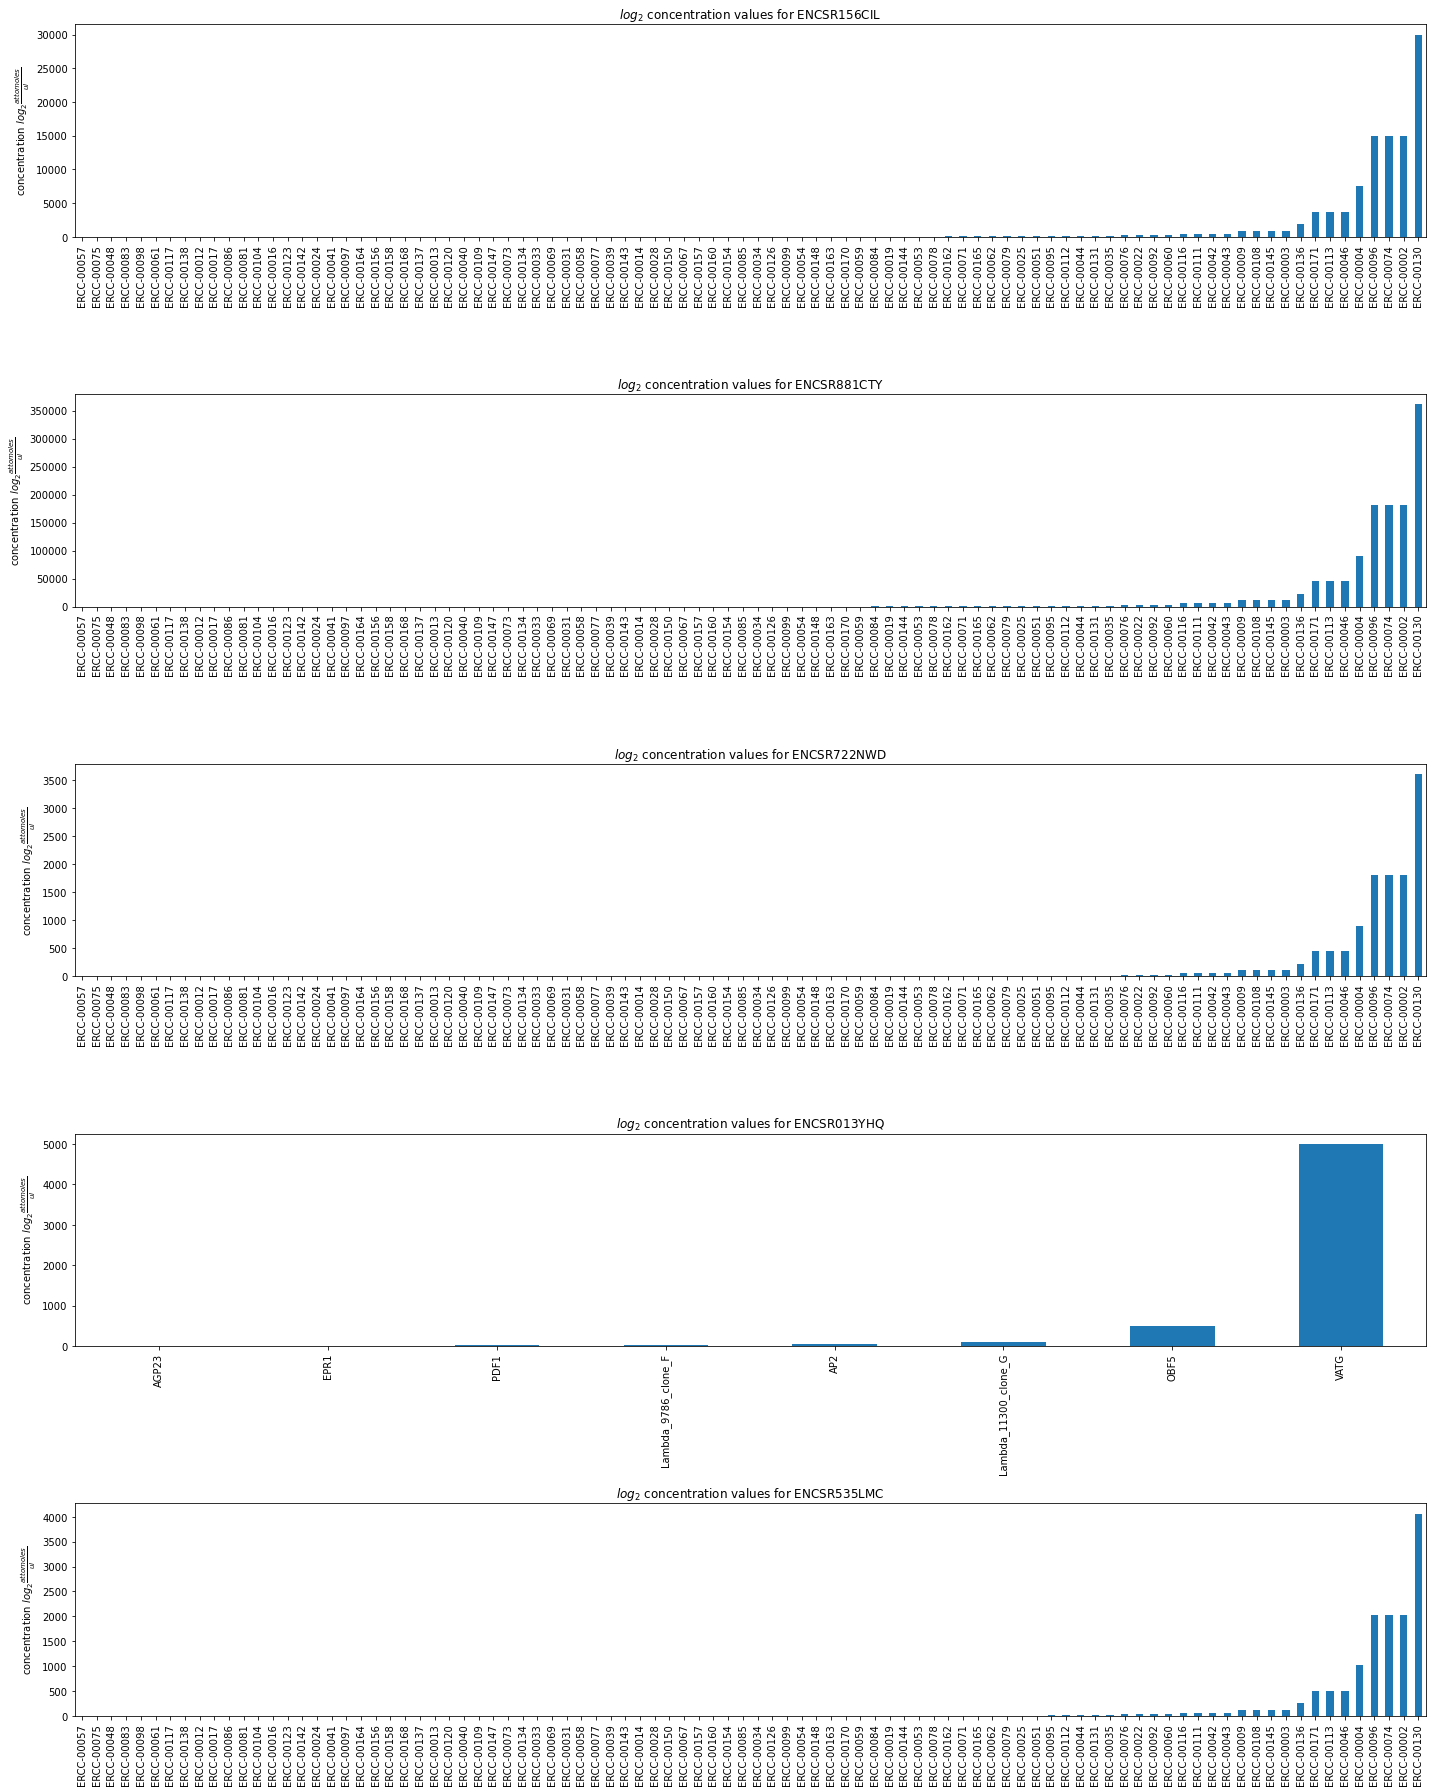

In [20]:
plot_spike_concentration(concentrations)

In [21]:
def plot_spike_concentration_log2(table):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        spike_count = len(table.columns)
        f = pyplot.figure(figsize=(20,5 * spike_count))
        axes = f.subplots(spike_count, 1, sharey=True)
        for i, column in enumerate(table.columns):
            axes[i].set_title('$log_2$ concentration values for {}'.format(column))
            axes[i].set_ylabel('concentration $log_2\\frac{attomoles}{ul}$')
            numpy.log2(table[column].dropna()).sort_values().plot.line(ax=axes[i])
        f.tight_layout()

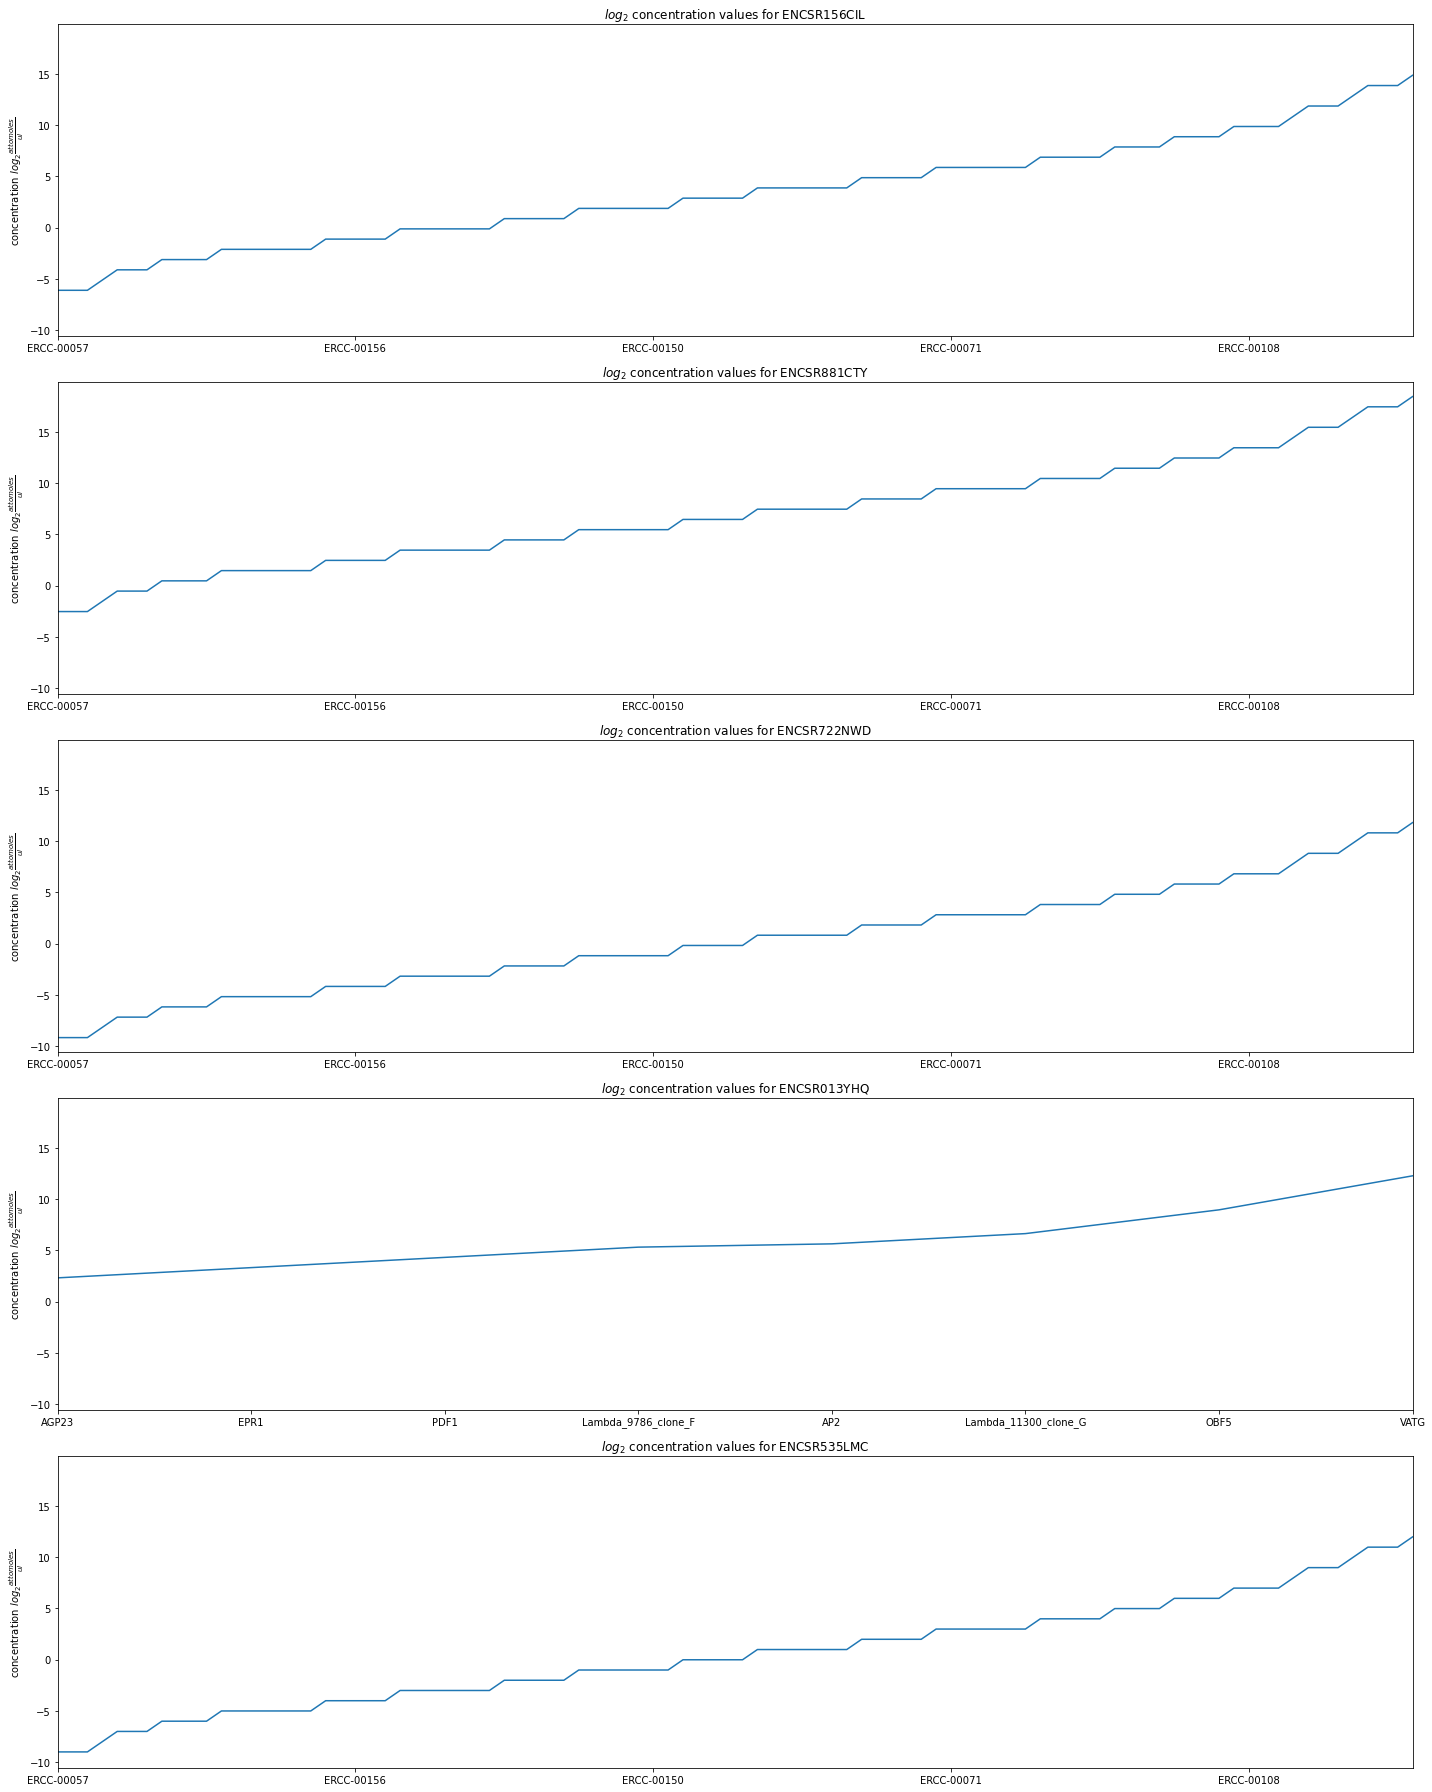

In [22]:
plot_spike_concentration_log2(concentrations)

In [23]:
def make_spike_dataframe(expression, spike_set_concentrations, library_ids=slice(None,None)):
    expression_spikes = [x for x in expression.var_names if x.startswith('gSpikein') or x.startswith('tSpikein')]
    short_spike_names = [x[len('gSpikein_'):] for x in expression_spikes]
    ordered_short_spikes = spike_set_concentrations.reindex(short_spike_names).sort_values().index
    ordered_spikes = ['gSpikein_' + x for x in ordered_short_spikes]
        
    table = expression[library_ids,ordered_spikes].to_df().T
    table.index = [ x[len('gSpikein_'):] for x in table.index ]
    return table

In [24]:
t = make_spike_dataframe(c1_cells_rsem_gene_counts, concentrations['ENCSR722NWD'], list(spikeins_used['ENCSR722NWD']))
t.head()

,18048_G4,18043_B2,18045_D10,18047_F4,18048_G3,18042_A5,18047_F7,18049_H11,18049_H9,18042_A7,...,18048_G12,18047_F8,18046_E7,18048_G8,18049_H2,18042_A11,18044_C2,18047_F1,18047_F2,18043_B7
ERCC-00057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


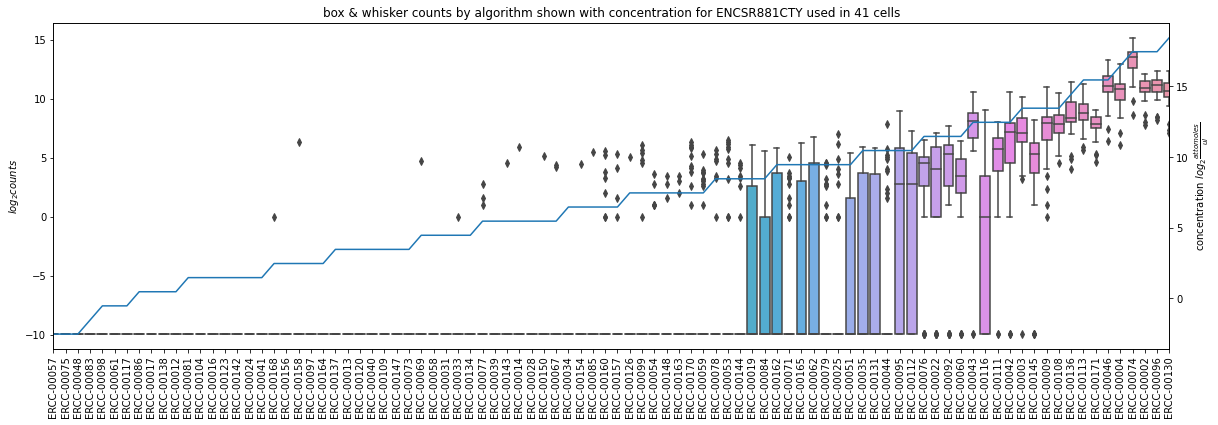

In [25]:
def plot_combined_median_spikes(expression, concentrations, spikes_used, spike_name, ax=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        quantification_name = expression.uns['quantification_name']
        spike_table = make_spike_dataframe(expression, concentrations[spike_name], list(spikeins_used[spike_name]))
        if ax is None:
            f= pyplot.figure(figsize=(20,6))
            ax=f.add_subplot(1,1,1)
        num_cells = spike_table.shape[1]
        ax.set_title(f'box & whisker {quantification_name} by algorithm shown with concentration for {spike_name} used in {num_cells} cells')
        ax.set_ylabel(f'$log_2 {quantification_name}$')
        ax2 = ax.twinx()
        ax2.set_ylabel('concentration $log_2\\frac{attomoles}{ul}$')

        sorted_concentration = concentrations[spike_name].reindex(spike_table.index).dropna().sort_values()
        #numpy.log2(spike_table+0.001).median(axis=1).plot(kind='bar', ax=ax)
        #numpy.log2(spike_table+0.001).T.boxplot(ax=ax)
        spike_table_log2 = numpy.log2(spike_table+0.001)
        seaborn.boxplot(data=spike_table_log2.reindex(sorted_concentration.index).T, ax=ax)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        numpy.log2(sorted_concentration).plot.line(ax=ax2) #, edgecolor='k', color='#00000000')

plot_combined_median_spikes(c1_cells_rsem_gene_counts, concentrations, spikeins_used, 'ENCSR881CTY')

In [26]:
def plot_single_cell_medians(expression):
    # those spikes were never added to the annotation
    usable_spikes = [x for x in spikeins_used.keys() if x != 'ENCSR013YHQ']

    num_spikes = len(usable_spikes)
    f = pyplot.figure(figsize=(16,4*num_spikes))
    axes = f.subplots(num_spikes, 1, sharex=False)
    for i, column in enumerate(usable_spikes):
        plot_combined_median_spikes(expression, concentrations, spikeins_used, column, ax=axes[i])
    f.tight_layout()

# Compare Median of single cell C1 RSEM  counts

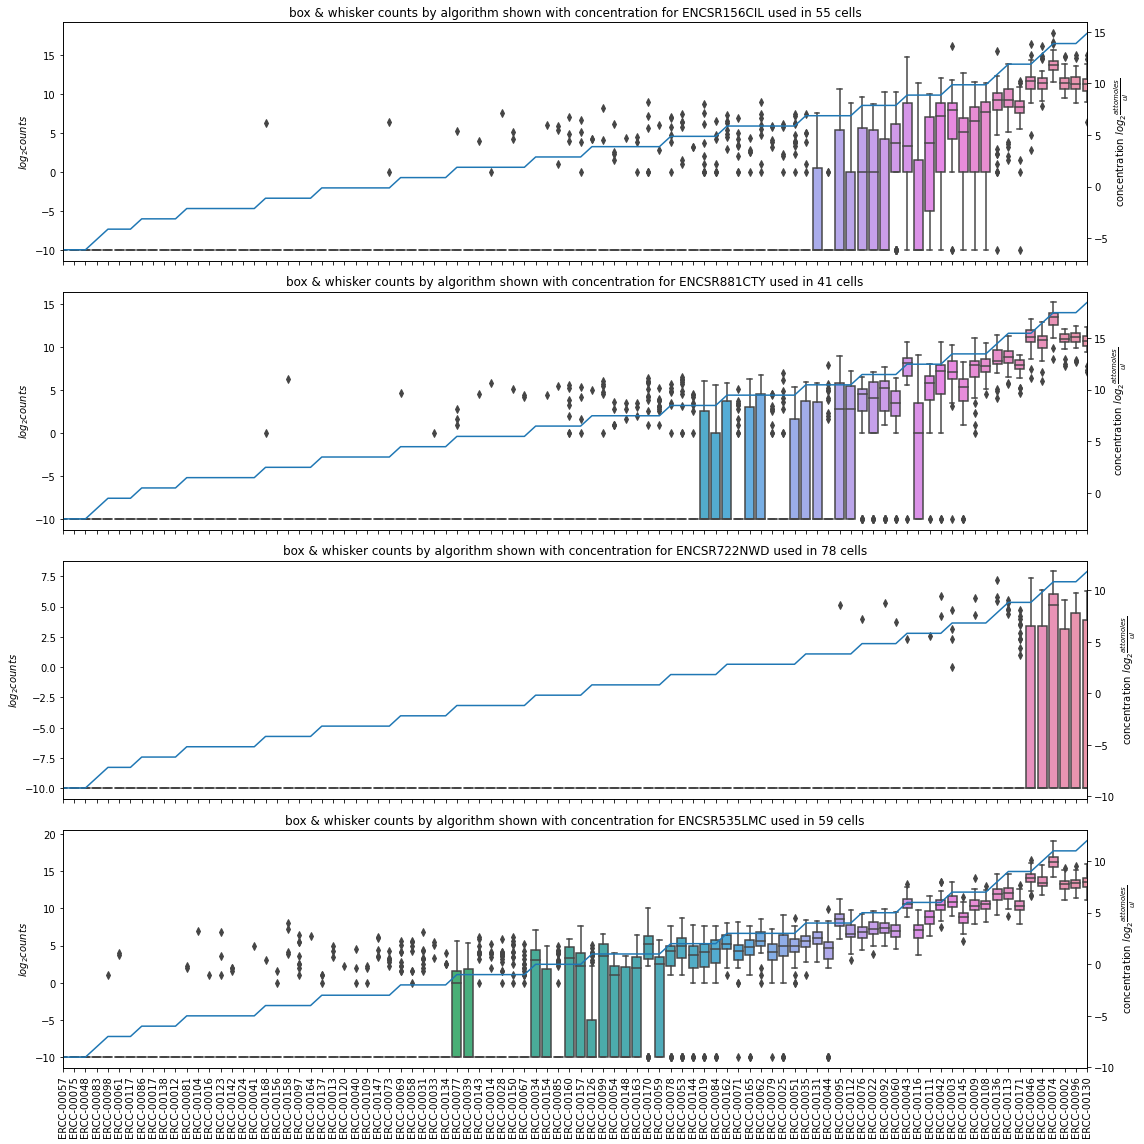

In [27]:
plot_single_cell_medians(c1_cells_rsem_gene_counts)

# Compare Median of single cell C1 RSEM  TPMs

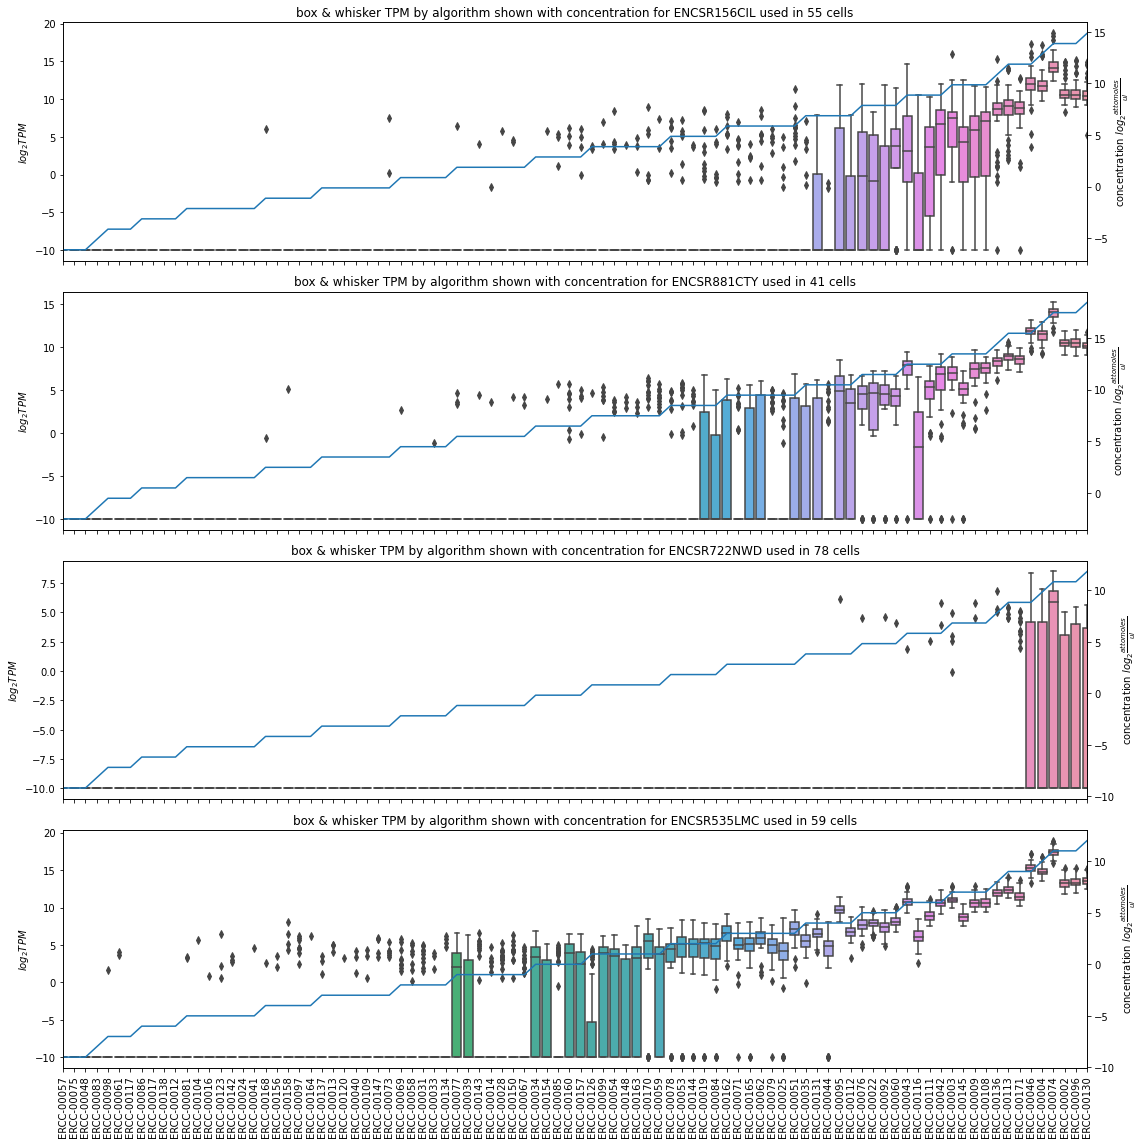

In [28]:
plot_single_cell_medians(c1_cells_rsem_gene_tpms)

In [29]:
def plot_combined_c1_spikes(expression, concentration, observations=slice(None,None)):
    quantification_name = expression.uns['quantification_name']
    spike_name = 'ENCSR156CIL'
    spike_table = make_spike_dataframe(expression, concentrations[spike_name], observations)
        
    #reindex = ['gSpikein_'+x for x in concentration[spike_name].sort_values().index if 'gSpikein_'+x in expression.var_names]
    f= pyplot.figure(figsize=(20,6))
    ax=f.add_subplot(1,1,1)
    ax.set_title(f'Detected {quantification_name} by algorithm shown with concentration for {spike_name}')
    ax.set_ylabel('$log_2 {quantification_name}$')
    ax2 = ax.twinx()
    ax2.set_ylabel('concentration $log_2\\frac{attomoles}{ul}$')
    spike_table_log2 = numpy.log2(spike_table+0.001)
    sorted_concentration = concentrations[spike_name].reindex(spike_table.index).dropna().sort_values()
    #print(spike_table_log2.reindex(sorted_concentration.index).T)
    spike_table_log2.reindex(sorted_concentration.index).plot.bar(ax=ax)
    #seaborn.boxplot(data=spike_table_log2.reindex(sorted_concentration.index).T, ax=ax)
    numpy.log2(concentrations[spike_name]).sort_values().plot.line(ax=ax2) #, edgecolor='k', color='#00000000')
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    

# Compare all algorithm counts

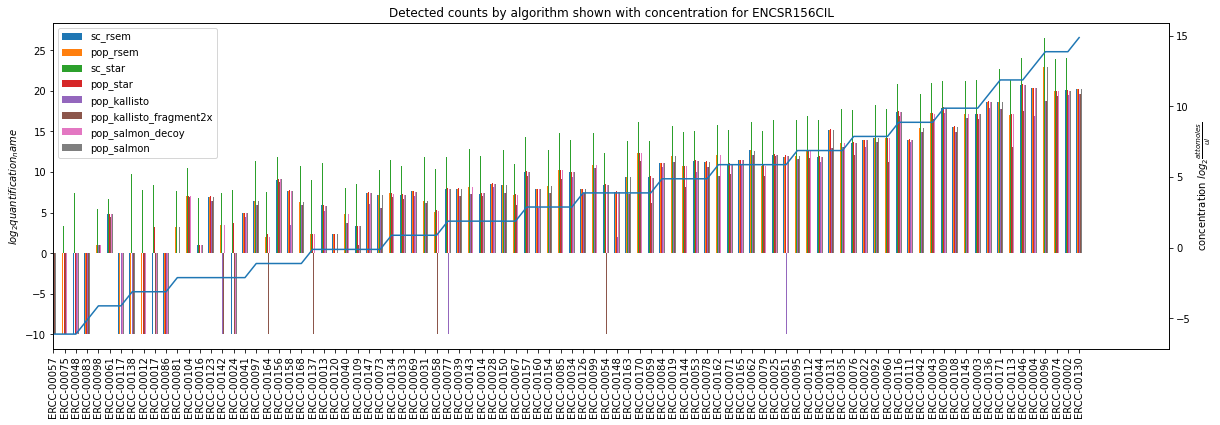

In [30]:
plot_combined_c1_spikes(c1_gene_counts, concentrations)

# Compare Single Cell RSEM and Pop RSEM counts

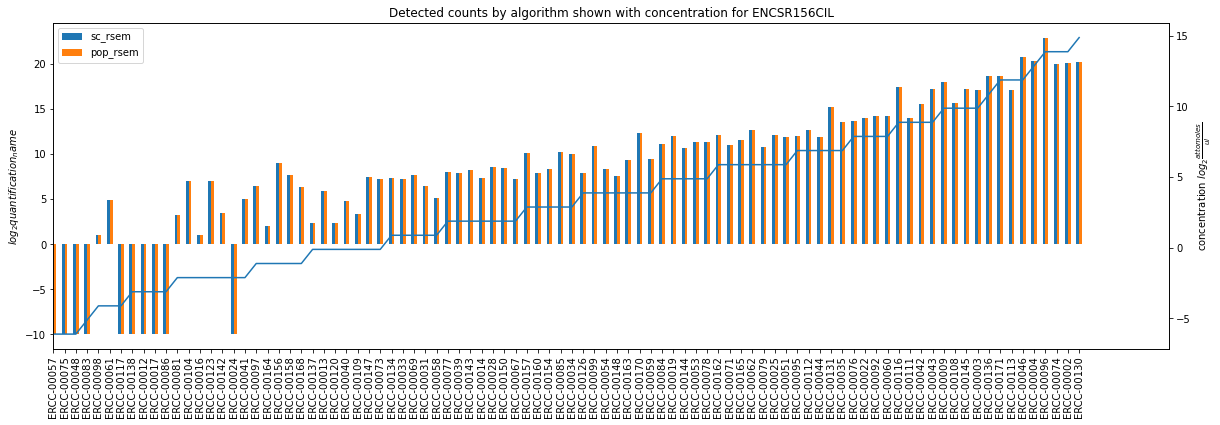

In [31]:
plot_combined_c1_spikes(c1_gene_counts, concentrations, ['sc_rsem', 'pop_rsem'])

# Compare C1 Gene single cell star and pop counts 

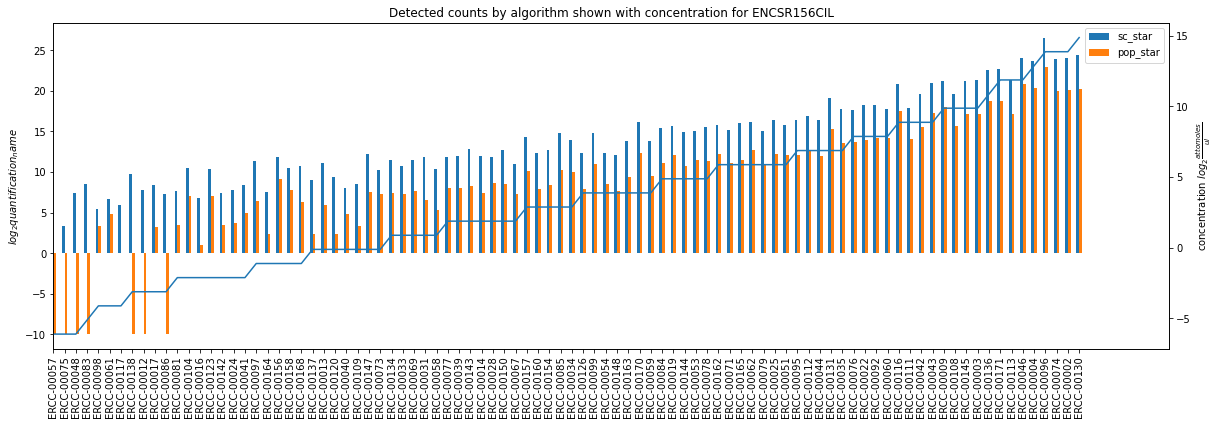

In [32]:
plot_combined_c1_spikes(c1_gene_counts, concentrations, ['sc_star', 'pop_star'])

# Compare Single Cell RSEM and Pop RSEM TPMs

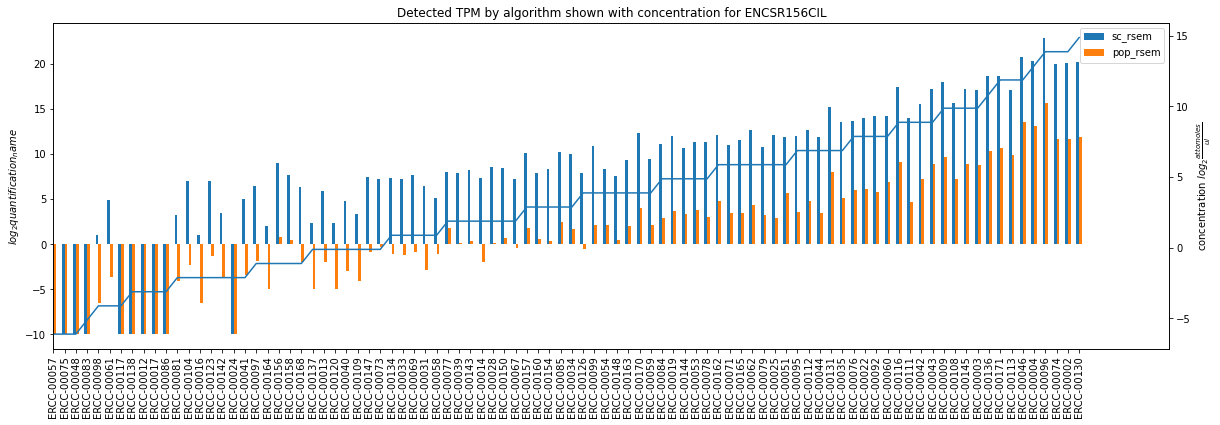

In [33]:
plot_combined_c1_spikes(c1_gene_tpms, concentrations, ['sc_rsem', 'pop_rsem'])

Looks like I should rerun the analyses with the cells that have a sane spike in mix. ENCSR535LMC

In [39]:
with open('c1-cells-using-ENCSR535LMC-spike.txt', 'wt') as outstream:
    for cell in sorted(spikeins_used['ENCSR535LMC']):
        outstream.write("{}\n".format(cell))

# Graveyard of bad plots

In [34]:
if 0:
    f = pyplot.figure(figsize=(3,16))
    ax = f.add_subplot(1,1,1)
    for x, algorithm in enumerate(c1_spike_counts.columns):
        y = range(len(c1_spike_counts[algorithm]))
        c = [spike_colors.get(x, '#000000') for x in c1_spike_counts[algorithm].sort_values().index]
        ax.scatter(x=[x] * len(y), y=y, c=c, marker='s')
    ax.set_xticks(range(len(c1_spike_counts.columns)))
    ax.set_xticklabels(c1_spike_counts.columns, rotation=90)
    #ax.set_yticks(range(len(c1_spike_counts.index)))
    #ax.set_yticklabels(c1_spike_counts.index)
    ax.scatter(x=[x+1] * len(y), y=y, c=[spike_colors.get(x, '#000000') for x in encsr156cil.sort_values('concentration').index], marker='s')
    pass

In [35]:
if 0:
    f = pyplot.figure(figsize=(16,3))
    ax = f.add_subplot(1,1,1)
    for x, algorithm in enumerate(c1_spike_counts.columns):
        y = range(len(c1_spike_counts[algorithm]))
        c = [spike_colors.get(x, '#000000') for x in c1_spike_counts[algorithm].sort_values().index]
        ax.scatter(y=[x] * len(y), x=y, c=c, marker='s')


    ax.scatter(y=[x+1] * len(y), x=y, c=[spike_colors.get(x, '#000000') for x in encsr156cil.sort_values('concentration').index], marker='s')

    ax.set_yticks(range(len(c1_spike_counts.columns)+1))
    labels = list(c1_spike_counts.columns)
    labels.append('expected')
    ax.set_yticklabels(labels)
    #ax.set_yticks(range(len(c1_spike_counts.index)))
    #ax.set_yticklabels(c1_spike_counts.index)
pass